<a href="https://colab.research.google.com/github/ntolayd/Projects/blob/main/Recommendation_Engines/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import warnings
import tensorflow as tf
import pickle
warnings.filterwarnings('ignore')

In [4]:
#data loading
!unzip "/content/gdrive/My Drive/ml-1m.zip"
masked = pd.read_csv('/content/gdrive/MyDrive/masked.csv')
test_set = pd.read_csv('/content/gdrive/MyDrive/test_set.csv')
with open(r'/content/gdrive/MyDrive/masked_idx.pkl', "rb") as input_file:
  masked_idx = pickle.load(input_file)
movies = pd.read_csv("ml-1m/movies.dat", sep='::', engine='python', header=None)
movies.columns = ['movie_id', 'movie_name', 'genre']
ratings = pd.read_csv("ml-1m/ratings.dat", sep='::', engine='python', header=None)
ratings.columns=['user_id', 'movie_id', 'rating','timestamp']

Archive:  /content/gdrive/My Drive/ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [5]:
masked = masked.set_index('user_id')
masked_arr = masked.copy().values

In [6]:
#replacing all nans with 0 and normalizing ratings between 0 and 1
masked_arr[np.isnan(masked_arr)] = 0
masked_arr = masked_arr / 5

In [7]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping

AutoRec Model


In [33]:

# Input
input_layer = Input(shape=(masked_arr.shape[1],), name='input_matrix')


# Bottleneck
latent_features = Dense(64, activation='sigmoid', name='latent_features')(input_layer)


# Output
output_layer = Dense(masked_arr.shape[1], activation='linear', name='output')(latent_features)

model = Model(input_layer, output_layer)    

In [34]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_matrix (InputLayer)    [(None, 3706)]            0         
_________________________________________________________________
latent_features (Dense)      (None, 64)                237248    
_________________________________________________________________
output (Dense)               (None, 3706)              240890    
Total params: 478,138
Trainable params: 478,138
Non-trainable params: 0
_________________________________________________________________


In [35]:
#referance: https://github.com/keras-team/keras/issues/7065#issuecomment-318002081
#masked mean squared error as loss function
import keras.backend  as K
def MMSE(y_true, y_pred):
  #mask value is 0
    mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
    masked_squared_error = K.square(mask_true * (y_true - y_pred))
    masked_mse = (K.sum(masked_squared_error, axis=-1) /
                  K.sum(mask_true, axis=-1))
    return masked_mse

In [36]:
model.compile(optimizer = Adam(lr=0.001), loss=MMSE)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

hist = model.fit(x=masked_arr, y=masked_arr,
                  epochs=200,
                  batch_size=128,
                  shuffle=True,
                  validation_split=0.1, verbose=0)

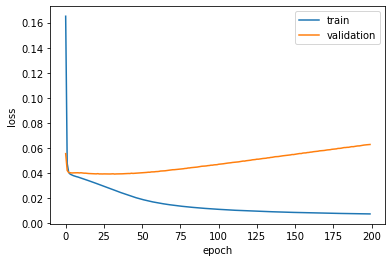

In [37]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

In [38]:
#reconstruction of input and rmse 
predicted_matrix_base = model.predict(masked_arr) * 5 #firstly make predictions 
predicted_matrix_base = pd.DataFrame(predicted_matrix_base, index=masked.index, columns=masked.columns) #converting preds into a df
preds_melted = pd.melt(predicted_matrix_base.reset_index(), id_vars=['user_id']) #melt predictions to be able to merge with testset
preds_melted.columns = ['user_id','movie_id', 'rating']
preds_melted['movie_id']=preds_melted['movie_id'].astype(int)
final_df = pd.merge(preds_melted, test_set, on=['user_id','movie_id']) #merge testset and predictions
final_df['diff'] = (final_df['rating_y'] - final_df['rating_x'])**2 #taking difference for rmse
print('final rmse:', np.sqrt(final_df['diff'].mean()))

final rmse: 1.1117499276760139


In [39]:
def recommender(user_id,n,prediction_matrix):
  recommend_df = prediction_matrix.loc[prediction_matrix.index==user_id].T.reset_index()
  recommend_df.columns = ['movie_id','ratings']
  recommend_df = recommend_df.sort_values(by='ratings', ascending=False).head(n)
  recommend_df['movie_id'] = recommend_df['movie_id'].astype(int)
  watched_movies = pd.merge(ratings[ratings['user_id'] == user_id].sort_values(by='rating',ascending=False).head(n), movies, on='movie_id')
  recommended_movies = pd.merge(recommend_df, movies, on='movie_id')
  #print(f'Watched movies by user {user_id}:', '\n', watched_movies[['movie_name','rating']],'\n')
  #print(f'Recommended movies to user {user_id}:', '\n', recommended_movies[['movie_name','ratings']])
  return recommended_movies[['movie_id','ratings']]

In [40]:
def apk(actual, predicted, k=10):

    if len(actual) == 0:
      return 0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)


    return score / min(len(actual), k)

In [41]:
def apk_user(user_id,k,prediction_matrix):
  mean_rating = masked[masked.index == user_id].mean(axis=1).values[0]
  user_test = test_set[test_set['user_id'] == user_id][['movie_id','rating']]
  user_liked_movies = user_test[user_test['rating'] >= mean_rating]['movie_id'].values
  recommended_movies = recommender(user_id,k,prediction_matrix)['movie_id'].values
  return apk(user_liked_movies, recommended_movies,k)

In [42]:
mean_apk_base = np.mean([apk_user(i,30, predicted_matrix_base) for i in masked.index.unique()])

In [43]:
mean_apk_base

0.0018774315151820439

DeepRec model


In [44]:
# Input
input_layer = Input(shape=(masked_arr.shape[1],), name='input_matrix')

# Encoder
encoder = Dense(512, activation='relu', name='encoder')(input_layer)
encoder =  Dropout(0.5)(encoder)
# Bottleneck
latent_features = Dense(64, activation='relu', name='latent_features')(encoder)
latent_features = Dropout(0.5)(latent_features)

# Decoder
decoder = Dense(512, activation='relu', name='decoder')(latent_features)

# Output
output_layer = Dense(masked_arr.shape[1], activation='linear', name='output')(decoder)

model = Model(input_layer, output_layer)  

In [45]:
model.compile(optimizer = Adam(lr=0.001), loss=MMSE)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

hist = model.fit(x=masked_arr, y=masked_arr,
                  epochs=200,
                  batch_size=128,
                  shuffle=True,
                  validation_split=0.1, verbose=0)

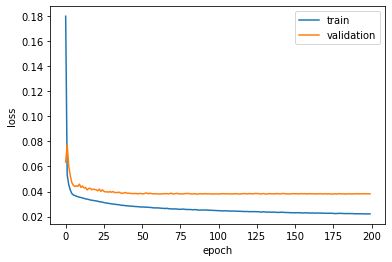

In [46]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

In [47]:
#reconstruction of input and rmse 
predicted_matrix_deep = model.predict(masked_arr) * 5 #firstly make predictions 
predicted_matrix_deep = pd.DataFrame(predicted_matrix_deep, index=masked.index, columns=masked.columns) #converting preds into a df
preds_melted = pd.melt(predicted_matrix_deep.reset_index(), id_vars=['user_id']) #melt predictions to be able to merge with testset
preds_melted.columns = ['user_id','movie_id', 'rating']
preds_melted['movie_id']=preds_melted['movie_id'].astype(int)
final_df = pd.merge(preds_melted, test_set, on=['user_id','movie_id']) #merge testset and predictions
final_df['diff'] = (final_df['rating_y'] - final_df['rating_x'])**2 #taking difference for rmse
print('final rmse:', np.sqrt(final_df['diff'].mean()))

final rmse: 0.9094279572053914


In [48]:
mean_apk_deep = np.mean([apk_user(i,30, predicted_matrix_deep) for i in masked.index.unique()])

In [49]:
mean_apk_deep

0.0022795489758459762

In [50]:
#improved DeepRec
# Input
input_layer = Input(shape=(masked_arr.shape[1],), name='input_matrix')

# Encoder
encoder = Dense(1024, activation='selu', name='encoder')(input_layer)
encoder = Dense(512, activation='selu', name='encoder2')(encoder)
encoder = Dropout(0.5)(encoder)

# Bottleneck
latent_features = Dense(64, activation='selu', name='latent_features')(encoder)
latent_features = Dropout(0.8)(latent_features)

# Decoder
decoder = Dense(512, activation='selu', name='decoder')(latent_features)
decoder = Dropout(0.5)(decoder)
decoder = Dense(1024, activation='selu', name='decoder2')(decoder)

# Output
output_layer = Dense(masked_arr.shape[1], activation='selu', name='output')(decoder)

model = Model(input_layer, output_layer)  


In [51]:
model.compile(optimizer = Adam(lr=0.001), loss=MMSE)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, restore_best_weights=True)

hist = model.fit(x=masked_arr, y=masked_arr,
                  epochs=200,
                  batch_size=128,
                  shuffle=True,
                  validation_split=0.1, verbose=0)

In [52]:
#reconstruction of input and rmse 
predicted_matrix_enhanced = model.predict(masked_arr) * 5 #firstly make predictions 
predicted_matrix_enhanced = pd.DataFrame(predicted_matrix_enhanced, index=masked.index, columns=masked.columns) #converting preds into a df
preds_melted = pd.melt(predicted_matrix_enhanced.reset_index(), id_vars=['user_id']) #melt predictions to be able to merge with testset
preds_melted.columns = ['user_id','movie_id', 'rating']
preds_melted['movie_id']=preds_melted['movie_id'].astype(int)
final_df = pd.merge(preds_melted, test_set, on=['user_id','movie_id']) #merge testset and predictions
final_df['diff'] = (final_df['rating_y'] - final_df['rating_x'])**2 #taking difference for rmse
print('final rmse:', np.sqrt(final_df['diff'].mean()))

final rmse: 0.9408182547627746


In [53]:
mean_apk_enhanced = np.mean([apk_user(i,30, predicted_matrix_enhanced) for i in masked.index.unique()])

In [54]:
mean_apk_enhanced

0.0006370092274684901

In [55]:
mean_apk_base

0.0018774315151820439

In [56]:
mean_apk_deep

0.0022795489758459762

In [57]:
mean_apk_enhanced

0.0006370092274684901